In [1]:
!pip install tensorflow-addons

In [2]:
import os
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.models import Model
#import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, utils
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt2
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras import regularizers
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [3]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
dataset_url = "https://www.kaggle.com/sophatvathana/casia-dataset"
od.download(dataset_url)

Skipping, found downloaded files in "./casia-dataset" (use force=True to force download)


In [4]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [5]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [6]:
image_size = (224, 224)

In [7]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [8]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [9]:
import random
path = '/content/casia-dataset/CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [10]:
path = '/content/casia-dataset/CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [11]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 224, 224, 3)

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


**Model Architecture**

In [13]:
def real_block(input, dim, drop_path=0.0):
     
     #shortcut connection
      shortcurt = input 
      x = layers.Conv2D(filters=dim, kernel_size=7, padding='same', groups=dim)(input)
      x = layers.LayerNormalization(epsilon=1e-6)(x)

      x = layers.Dense(4 * dim)(x)
      x = layers.BatchNormalization()(x)
      x = layers.ReLU()(x)
      x = layers.Dense(dim)(x)
      #Stochastic depth
      drop_depth = tfa.layers.StochasticDepth(drop_path) if drop_path > 0.0 else layers.Activation("linear")

      output = layers.Add()([shortcurt, drop_depth(x)])

      return output

In [14]:
def stem(input, dim):

  x = layers.Conv2D(filters=dim, kernel_size=4, strides=4)(input)
  x = layers.BatchNormalization()(x)

  return x

In [15]:
def downsampling_layers(input, dim):

#   x = layers.LayerNormalization(epsilon=1e-6)(input)
  x = layers.BatchNormalization() (input)
  x = layers.Conv2D(filters=dim, kernel_size=2, strides=2)(x)

  return x

In [16]:
def real_model(input_shape=(224, 224, 3), dims=[96, 192, 384, 768], num_classes=2):

  input = layers.Input(input_shape)

  # stem
  x = stem(input, dims[0])

  # Stage 1 x3, dim[0] = 64
  for _ in range(1):
    x = real_block(x, dims[0])

  # Downsampling layers + stage 2 x3, dim[1] = 128
  x = downsampling_layers(x, dims[1])
  for _ in range(3):
    x = real_block(x, dims[1])

  # Downsampling layers + stage 3 x7, dim[2] = 256
  x = downsampling_layers(x, dims[2])
  for _ in range(6):
    x = real_block(x, dims[2])

  # Downsampling layers + stage 4 x3, dim[3] = 512
  x = downsampling_layers(x, dims[3])
  for _ in range(1):
    x = real_block(x, dims[3])
    
  # Classification head: Global average pool + layer norm + fully connected layer
  x = layers.GlobalAvgPool2D()(x)

  x = layers.LayerNormalization(epsilon=1e-6)(x)    
  x = layers.Dense(units= dims[3], activation='relu') (x)
  x = layers.Dropout(0.2) (x)
  output = layers.Dense(units=num_classes, activation='softmax')(x)

  model = keras.Model(input, output, name='FNet')

  return model

**Model Summary**

In [17]:
model= real_model()
model.summary()

Model: "FNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 56, 56, 96)   4704        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 56, 56, 96)  384         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                               

**Training Model**

In [18]:
epochs = 30
batch_size = 32
init_lr = 1e-5
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
checkpoint = ModelCheckpoint(filepath='/content/Model_weights/FNet_CASIA.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=2, 
                              verbose=1
                             )
csv_logger = CSVLogger('training.log')

early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0.001,
                              patience =3,
                              verbose = 0,
                              mode = 'auto')

callbacks = [checkpoint, reduce_lr, early_stopping, csv_logger]

In [20]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [21]:
%%time
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                 validation_data = (X_val, Y_val),
                 verbose = 1)

Epoch 1/30
105/105 [==============================] - 48s 366ms/step - loss: 0.5113 - accuracy: 0.7763 - val_loss: 2.1303 - val_accuracy: 0.4886
Epoch 2/30
105/105 [==============================] - 37s 350ms/step - loss: 0.3521 - accuracy: 0.8616 - val_loss: 1.2292 - val_accuracy: 0.4886
Epoch 3/30
105/105 [==============================] - 37s 356ms/step - loss: 0.2718 - accuracy: 0.8997 - val_loss: 1.0401 - val_accuracy: 0.4886
Epoch 4/30
105/105 [==============================] - 38s 360ms/step - loss: 0.2144 - accuracy: 0.9177 - val_loss: 1.0002 - val_accuracy: 0.5378
Epoch 5/30
105/105 [==============================] - 38s 363ms/step - loss: 0.1237 - accuracy: 0.9601 - val_loss: 0.9858 - val_accuracy: 0.5462
Epoch 6/30
105/105 [==============================] - 39s 367ms/step - loss: 0.0877 - accuracy: 0.9736 - val_loss: 0.8051 - val_accuracy: 0.7227
Epoch 7/30
105/105 [==============================] - 39s 370ms/step - loss: 0.0368 - accuracy: 0.9871 - val_loss: 0.3457 - val_ac

**Accuracy and Loss**

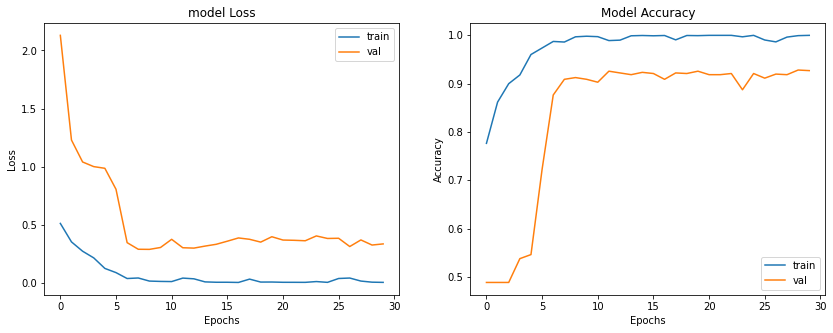

In [32]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

**Confusion Matrix**

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

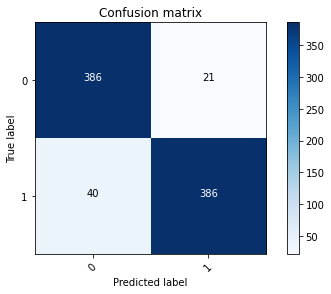

In [24]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

**Test Accuracy**

In [25]:
class_names = ['fake', 'real']

In [26]:
fake_image = os.listdir('/content/casia-dataset/CASIA2/Tp/')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join('/content/casia-dataset/CASIA2/Tp/', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 224, 224, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1

In [27]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 2064, Correct: 2042, Acc: 98.93410852713178


In [28]:
real_image = os.listdir('/content/casia-dataset/CASIA2/Au/')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join('/content/casia-dataset/CASIA2/Au/', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 224, 224, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


In [29]:
correct += correct_r
total += total_r
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 7354, Correct: 6737, Acc: 91.61000815882512
Total: 9418, Correct: 8779, Acc: 93.21511998301125
